In [68]:
import os
import trompy as tp
import numpy as np
import matplotlib.pyplot as plt


%run "..//src//vgp_helper_fx"

In [69]:
ROOT_FOLDER = "D:\\VGP"

DATA_FOLDER = os.path.join(ROOT_FOLDER, "2P\\proc_s2p\\")
BEHAV_FOLDER = os.path.join(ROOT_FOLDER, "Bonsai\\")
METAFILE = os.path.join(ROOT_FOLDER, "Metafile_VGP2.4.xls")
rows, header = tp.metafilereader(METAFILE, sheetname="Analysis_Cas+malt")


File is excel file. Making csv metafile first


In [70]:
# Goes through metafile assembling data from s2p files where possible

cell_data={}

for row in rows:
    try:
        key=row[0]+'_'+row[3]
        animal=row[0]
        day=row[2]
        date=int(row[1])
        events=row[6]
#         solution=row[3]
        
        s2p_folder = os.path.join(DATA_FOLDER,
                                  "sub-{}\\ses-{}-{}\\suite2p\\plane0"
                                  .format(animal, day, date))
        events_file =BEHAV_FOLDER+events
        
        
        cell_data[key] = assemble_data(s2p_folder,events_file)
        cell_data[key]['animal'] = row[0]
        cell_data[key]['diet'] = row[11]
        cell_data[key]['session'] = row[3]
        
    except FileNotFoundError:
        print('Cannot find file for', key)
     

Cannot find file for VGP307_C3
Cannot find file for VGP402_C1


In [71]:
cell_data['VGP118_C1'].keys()

dict_keys(['animal', 'diet', 'solution', 'raw_F', 'neu_F', 'iscell', 'pump_snips_all', 'pump_responsive', 'lick_snips_all', 'lick_responsive', 'df_responsive', 'session'])

<AxesSubplot:>

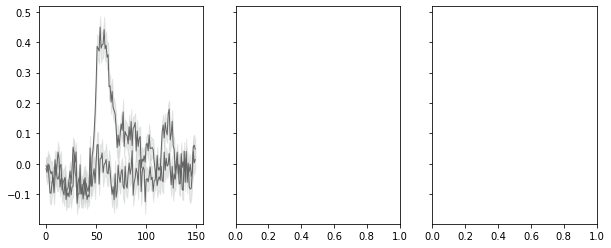

In [72]:
#Get lick responsive snips

# for key in cell_data.keys():
#     d=cell_data[key]
    
#     if d[]

lick_snips=np.mean(cell_data['VGP302_C1']['lick_snips_all'][np.where(cell_data['VGP302_C1']['lick_responsive']==1)],axis=1)
snips_nonres=np.mean(cell_data['VGP302_C1']['lick_snips_all'][np.where(cell_data['VGP302_C1']['lick_responsive']==0)],axis=1)


f, ax = plt.subplots(figsize=(10,4),ncols=3, sharey=True)
tp.shadedError(ax[0], lick_snips, linecolor="#636363")
tp.shadedError(ax[0], snips_nonres, linecolor="#636363")


In [73]:
PR_C1_licks_act=[]
PR_C1_licks_nonres=[]

PR_C2_licks_act=[]
PR_C2_licks_nonres=[]

PR_C3_licks_act=[]
PR_C3_licks_nonres=[]

animal=[]

for key in cell_data.keys():
    d=cell_data[key]
    if d['diet']=='PR' and d['session']=='C1':
        lick_snips=(np.mean(d['lick_snips_all'][np.where(d['lick_responsive']==1)],axis=1)) 
        PR_C1_licks_act.append(np.mean(lick_snips, axis=0))
#         snips_non=(np.mean(d['lick_snips_all'][np.where(d['lick_responsive']==0)],axis=1)) 
#         PR_C1_licks_nonres.append(np.mean(snips_non, axis=0))
        
    elif d['diet']=='PR' and d['session']=='C2':
        animal.append(d['animal'])
        lick_snips=(np.mean(d['lick_snips_all'][np.where(d['lick_responsive']==1)],axis=1)) 
        PR_C2_licks_act.append(np.mean(lick_snips, axis=0))
#         snips_non=(np.mean(d['lick_snips_all'][np.where(d['lick_responsive']==0)],axis=1)) 
#         PR_C2_licks_nonres.append(np.mean(snips_non, axis=0))
    
    elif d['diet']=='PR' and d['session']=='C3':
        animal.append(d['animal'])
        lick_snips=(np.mean(d['lick_snips_all'][np.where(d['lick_responsive']==1)],axis=1)) 
        PR_C3_licks_act.append(np.mean(lick_snips, axis=0))
#         snips_non=(np.mean(d['lick_snips_all'][np.where(d['lick_responsive']==0)],axis=1)) 
#         PR_C3_licks_nonres.append(np.mean(snips_non, axis=0))

#Filtering out empty arrays        
PR_C2_licks_act_f=[]        
for animal in PR_C2_licks_act: 
    if not np.isnan(animal).any(): 
        PR_C2_licks_act_f.append(animal)

C:\Users\mko102\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mko102\Anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [74]:
PR_M1_licks_act=[]
PR_M2_licks_act=[]
PR_M3_licks_act=[]


animal=[]

for key in cell_data.keys():
    d=cell_data[key]
    if d['diet']=='PR' and d['session']=='M1':
        lick_snips=(np.mean(d['lick_snips_all'][np.where(d['lick_responsive']==1)],axis=1)) 
        PR_M1_licks_act.append(np.mean(lick_snips, axis=0))
        
    elif d['diet']=='PR' and d['session']=='M2':
        animal.append(d['animal'])
        lick_snips=(np.mean(d['lick_snips_all'][np.where(d['lick_responsive']==1)],axis=1)) 
        PR_M2_licks_act.append(np.mean(lick_snips, axis=0))       
    
    elif d['diet']=='PR' and d['session']=='M3':
        lick_snips=(np.mean(d['lick_snips_all'][np.where(d['lick_responsive']==1)],axis=1)) 
        PR_M3_licks_act.append(np.mean(lick_snips, axis=0))
        
print(animal)
PR_M2_licks_act_f=[]        
for animal in PR_M2_licks_act: 
    if not np.isnan(animal).any(): 
        PR_M2_licks_act_f.append(animal)

['VGP203', 'VGP118', 'VGP302', 'VGP306', 'VGP307', 'VGP402', 'VGP505', 'VGP506', 'VGP509']


In [83]:
NR_C1_licks_act=[]
NR_C2_licks_act=[]
NR_C3_licks_act=[]

animal=[]

for key in cell_data.keys():
    d=cell_data[key]
    if d['diet']=='NR' and d['session']=='C1':
        lick_snips=(np.mean(d['lick_snips_all'][np.where(d['lick_responsive']==1)],axis=1)) 
        NR_C1_licks_act.append(np.mean(lick_snips, axis=0))

        
    elif d['diet']=='NR' and d['session']=='C2':
        animal.append(d['animal'])
        lick_snips=(np.mean(d['lick_snips_all'][np.where(d['lick_responsive']==1)],axis=1)) 
        NR_C2_licks_act.append(np.mean(lick_snips, axis=0))

    
    elif d['diet']=='NR' and d['session']=='C3':
        animal.append(d['animal'])
        lick_snips=(np.mean(d['lick_snips_all'][np.where(d['lick_responsive']==1)],axis=1)) 
        NR_C3_licks_act.append(np.mean(lick_snips, axis=0))




NR_C3_licks_act_f=[]        
for animal in NR_C3_licks_act: 
    if not np.isnan(animal).any(): 
        NR_C3_licks_act_f.append(animal)


In [89]:
NR_M1_licks_act=[]
NR_M2_licks_act=[]
NR_M3_licks_act=[]


animal=[]

for key in cell_data.keys():
    d=cell_data[key]
    if d['diet']=='NR' and d['session']=='M1':
        lick_snips=(np.mean(d['lick_snips_all'][np.where(d['lick_responsive']==1)],axis=1)) 
        NR_M1_licks_act.append(np.mean(lick_snips, axis=0))
        
    elif d['diet']=='NR' and d['session']=='M2':
        animal.append(d['animal'])
        lick_snips=(np.mean(d['lick_snips_all'][np.where(d['lick_responsive']==1)],axis=1)) 
        NR_M2_licks_act.append(np.mean(lick_snips, axis=0))

    elif d['diet']=='NR' and d['session']=='M3':
        animal.append(d['animal'])
        lick_snips=(np.mean(d['lick_snips_all'][np.where(d['lick_responsive']==1)],axis=1)) 
        NR_M3_licks_act.append(np.mean(lick_snips, axis=0))



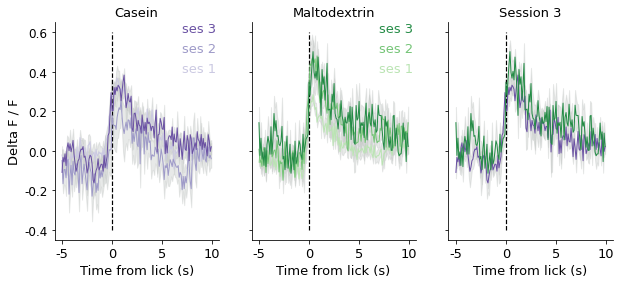

In [129]:
f, ax = plt.subplots(figsize=(10,4),ncols=3, sharey=True)

tp.shadedError(ax[0], PR_C1_licks_act, linecolor="#cbc9e2")

tp.shadedError(ax[0], PR_C2_licks_act_f, linecolor="#9e9ac8")

tp.shadedError(ax[0], PR_C3_licks_act, linecolor="#6a51a3")



tp.shadedError(ax[1], PR_M1_licks_act, linecolor="#bae4b3")

tp.shadedError(ax[1], PR_M2_licks_act_f, linecolor="#74c476")

tp.shadedError(ax[1], PR_M3_licks_act, linecolor="#238b45")


tp.shadedError(ax[2], PR_C3_licks_act, linecolor="#6a51a3")
tp.shadedError(ax[2], PR_M3_licks_act, linecolor="#238b45")


ax[0].text(120, 0.4, "ses 1",color='#cbc9e2', size=13)
ax[0].text(120, 0.5, "ses 2", color="#9e9ac8",size=13)
ax[0].text(120, 0.6, "ses 3", color="#6a51a3",size=13)

ax[1].text(120, 0.4, "ses 1",color='#bae4b3', size=13)
ax[1].text(120, 0.5, "ses 2", color="#74c476",size=13)
ax[1].text(120, 0.6, "ses 3", color="#238b45",size=13)


for axis in ax:
    axis.set_xticks([0,50,100,150])
    axis.set_xticklabels(["-5", "0", "5", "10"],rotation=0, size=13)
    axis.set_yticks([-0.4,-0.2, 0.0, 0.2,0.4,0.6])
    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)
    axis.vlines([50],-0.4,0.6, color="black", linestyle="--", linewidth=1.2)
    axis.set_xlabel("Time from lick (s)", size=13)


ax[0].set_ylabel("Delta F / F", size=13)
ax[0].set_yticklabels([-0.4,-0.2, 0.0, 0.2,0.4,0.6], size=12)

ax[0].set_title('Casein', size=13)
ax[1].set_title('Maltodextrin', size=13)
ax[2].set_title('Session 3', size=13)


f.savefig("..//output//PR_licksnips_casmalt.pdf")


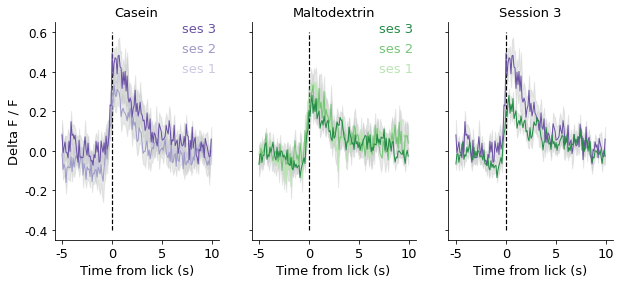

In [130]:
f, ax = plt.subplots(figsize=(10,4),ncols=3, sharey=True)

tp.shadedError(ax[0], NR_C1_licks_act, linecolor="#cbc9e2")

tp.shadedError(ax[0], NR_C2_licks_act, linecolor="#9e9ac8")

tp.shadedError(ax[0], NR_C3_licks_act_f, linecolor="#6a51a3")



tp.shadedError(ax[1], NR_M1_licks_act, linecolor="#bae4b3")

tp.shadedError(ax[1], NR_M2_licks_act, linecolor="#74c476")

tp.shadedError(ax[1], NR_M3_licks_act, linecolor="#238b45")


tp.shadedError(ax[2], NR_C3_licks_act_f, linecolor="#6a51a3")
tp.shadedError(ax[2], NR_M3_licks_act, linecolor="#238b45")

for axis in ax:
    axis.set_xticks([0,50,100,150])
    axis.set_xticklabels(["-5", "0", "5", "10"],rotation=0, size=13)
    axis.set_yticks([-0.4,-0.2, 0.0, 0.2,0.4,0.6])
    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)
    axis.vlines([50],-0.4,0.6, color="black", linestyle="--", linewidth=1.2)
    axis.set_xlabel("Time from lick (s)", size=13)


ax[0].set_ylabel("Delta F / F", size=13)
ax[0].set_yticklabels([-0.4,-0.2, 0.0, 0.2,0.4,0.6], size=12)


ax[0].text(120, 0.4, "ses 1",color='#cbc9e2', size=13)
ax[0].text(120, 0.5, "ses 2", color="#9e9ac8",size=13)
ax[0].text(120, 0.6, "ses 3", color="#6a51a3",size=13)

ax[1].text(120, 0.4, "ses 1",color='#bae4b3', size=13)
ax[1].text(120, 0.5, "ses 2", color="#74c476",size=13)
ax[1].text(120, 0.6, "ses 3", color="#238b45",size=13)

ax[0].set_title('Casein', size=13)
ax[1].set_title('Maltodextrin', size=13)
ax[2].set_title('Session 3', size=13)


f.savefig("..//output//NR_licksnips_casmalt.pdf")

In [79]:
cols = ["animal", "diet", "session", "lick_activated"]
df_activated = pd.DataFrame(columns=cols)

for key, d in cell_data.items():
    percent_act = d["df_responsive"].loc["lick_all", "activated"] / np.sum(d["df_responsive"].loc['pump_only':'neither',"activated"]) * 100
    data = np.array([d["animal"], d["diet"], d["solution"], percent_act])
    df_temp = pd.DataFrame({col: value for col, value in zip(cols, data)},
                          index=[key.split("_")[0]]).astype({'lick_activated':'float'})
    

    df_activated = pd.concat([df_activated, df_temp])
    
    
df_activated

,animal,diet,session,lick_activated
VGP118,VGP118,PR,ns,38.095238
VGP202,VGP202,NR,ns,40.000000
VGP203,VGP203,PR,ns,29.310345
VGP204,VGP204,NR,ns,15.789474
VGP118,VGP118,PR,ns,10.000000
...,...,...,...,...
VGP503,VGP503,NR,ns,11.111111
VGP504,VGP504,NR,ns,35.714286
VGP505,VGP505,PR,ns,32.786885
VGP506,VGP506,PR,ns,2.631579


In [13]:
df_pref = (df_activated.pivot_table(index=["animal", "diet"],
                         columns=["solution"],
                         values="lick_activated",
                         aggfunc="mean")
             .astype({"Cas": "float", "Malt": "float"})
#              .assign(pref=lambda df_: df_.cas / (df_.cas + df_.malt))
             .assign(pref=lambda df_: df_.Cas - df_.Malt)
            )


KeyError: 'solution'

In [ ]:
df_pref

In [ ]:
PRs = ["PR"]
NRs = ["NR"]

(df_pref
 .droplevel(0)
 .pref
 .reset_index()
 .query("diet in @PRs")
 .mean()
#  .loc["PR"]
)



Dataframes for each group (NR and PR) Casein and maltodextrin activated cells

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Making dataframe for NR-NRPR group
df_NR_cas = (df_pref
 .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="Cas")
#  .fillna(0)
 .assign(NR=lambda df_:df_.NR,
         NRPR=lambda df_:df_.NRPR)
 .drop(columns=["PR", "PRNR"])
 .dropna()
)

df_NR_malt = (df_pref
 .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="Malt")
#  .fillna(0)
 .assign(NR=lambda df_:df_.NR,
         NRPR=lambda df_:df_.NRPR)
 .drop(columns=["PR", "PRNR"])
 .dropna()
)

# Making dataframe for PR-PRNR group
df_PR_cas = (df_pref
 .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="Cas")
#  .fillna(0)
 .assign(PR=lambda df_:df_.PR,
         PRNR=lambda df_:df_.PRNR)
 .drop(columns=["NR", "NRPR"])
 .dropna()
)

df_PR_malt = (df_pref
 .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="Malt")
#  .fillna(0)
 .assign(PR=lambda df_:df_.PR,
         PRNR=lambda df_:df_.PRNR)
 .drop(columns=["NR", "NRPR"])
 .dropna()
)


print(df_NR_malt)
print(df_NR_cas)
print(df_PR_malt)
print(df_PR_cas)



Figure for cells activated by casein and maltodextrin

In [ ]:
NR_cas=[]
NRPR_cas=[]
for row in df_NR_cas.iterrows():
    NR_cas.append(row[1].NR)
    NRPR_cas.append(row[1].NRPR)

NR_malt=[]
NRPR_malt=[]
for row in df_NR_malt.iterrows():
    NR_malt.append(row[1].NR)
    NRPR_malt.append(row[1].NRPR)
    
    
PR_cas=[]
PRNR_cas=[]
for row in df_PR_cas.iterrows():
    PR_cas.append(row[1].PR)
    PRNR_cas.append(row[1].PRNR)

PR_malt=[]
PRNR_malt=[]
for row in df_PR_malt.iterrows():
    PR_malt.append(row[1].PR)
    PRNR_malt.append(row[1].PRNR)

    

colors_1=['#762a83', '#af8dc3','#7fbf7b','#1b7837']


f,ax=plt.subplots(figsize=(4.5,5), ncols=1, nrows=2, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.5, bottom=0.05, left=0.25)

tp.barscatter([[NR_cas,NRPR_cas],[PR_cas,PRNR_cas]], 
              paired= True,
              barfacecolor=colors_1,
              barfacecolor_option="individual",
              barlabels=['NR', 'NRPR', 'PR', 'PRNR'],
              fontsize = 13,
              scattersize=110,
              scatteralpha=0.9,
              spaced=True,
              linewidth=1.5,
              ax=ax[0],
              show_legend=False)

tp.barscatter([[NR_malt,NRPR_malt],[PR_malt,PRNR_malt]], 
              paired= True,
              barfacecolor=colors_1,
              barfacecolor_option="individual",
              barlabels=['NR', 'NRPR', 'PR', 'PRNR'],
              fontsize = 13,
              scattersize=110,
              scatteralpha=0.9,
              spaced=True,
              linewidth=1.5,
              ax=ax[1],
              show_legend=False)

ax[0].set_ylabel('% of cells \n activated by lick',fontsize = 13)
ax[0].set_yticks([0,20,40,60])
ax[0].set_yticklabels([0,20,40,60], fontsize = 13)

ax[1].set_ylabel('% of cells \n activated by lick',fontsize = 13)
ax[1].set_yticks([0,20,40,60])
ax[1].set_yticklabels([0,20,40,60], fontsize = 13)


ax[0].set_title('Casein', fontsize =15)
ax[1].set_title('Maltodextrin', fontsize =15)

f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\%_lick_activated_cells.png')

Dataframes for each group (NR and PR) Preferense

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Making dataframe for NR-NRPR group
df_NR = (df_pref
 .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="pref")
#  .fillna(0)
 .assign(NR=lambda df_:df_.NR,
         NRPR=lambda df_:df_.NRPR)
 .drop(columns=["PR", "PRNR"])
 .dropna()
)

# Making dataframe for PR-PRNR group
df_PR = (df_pref
 .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="pref")
#  .fillna(0)
 .assign(PR=lambda df_:df_.PR,
         PRNR=lambda df_:df_.PRNR)
 .drop(columns=["NR", "NRPR"])
 .dropna()
)

# print(df_NR)
# print(df_PR)





Figure for proportion of cells activated by casin - malodextrin

In [ ]:
f, ax = plt.subplots(figsize=(4,4))
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.3)


x1 = [1,2]
x2=[3,4]
for row in df_NR.iterrows():
    y = [row[1].NR,row[1].NRPR]
#     print(y)
    ax.plot(x1, y, color="grey")
    ax.scatter(x1, y, s=150, color=["#762a83", "#af8dc3"], zorder=20, alpha=0.8)

for row in df_PR.iterrows():
    y = [row[1].PR,row[1].PRNR]
#     print(y)
    ax.plot(x2, y, color="grey")
    ax.scatter(x2, y, s=150, color=["#7fbf7b", "#1b7837"], zorder=20, alpha=0.8)

  
    
ax.bar(x1, [df_NR.NR.mean(), df_NR.NRPR.mean()], width=0.7, zorder=-1, color="lightgrey")
ax.bar(x2, [df_PR.PR.mean(), df_PR.PRNR.mean()], width=0.7, zorder=-1, color="lightgrey")
    
ax.set_ylabel("Proportion of cells activated \n by casein vs maltodextrin", size=13)
ax.set_yticks([-40,-20,0,20,40])
ax.set_yticklabels(['-40','-20','0','20','40'], size=13)

ax.set_xticks([1,2,3,4])
ax.set_xticklabels(["NR", 'NRPR','PR','PRNR'], size=13)
ax.set_xlim([0.4,4.6])

ax.axhline(0, color="k", linestyle="--", zorder=-1,lw=1.2)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\pref_casein_cells.png')

In [ ]:
df_diet1 = (df_pref
#  .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="pref")
#  .fillna(0)
 .assign(PR=lambda df_: df_.PR,
         PRNR=lambda df_:df_.PRNR,
         NR=lambda df_:df_.NR,
         NRPR=lambda df_:df_.NRPR,
)
 .drop(columns=["NRPR", "PRNR"])
)



In [ ]:
my_colors = {'NR': '#525252', 'PR': '#2171b5'}

'','','',''
f, ax = plt.subplots(figsize=(6,3),
                     gridspec_kw={"left": 0.25, "bottom": 0.2})

sns.boxplot(data=df_diet1,orient="h", ax=ax, palette=my_colors)


ax.set_ylabel("")
ax.set_yticklabels(["NR", "PR"])
ax.set_xticks([-30, 0, 20, 30])
ax.set_xlabel("Lick-activated cells (casein - maltodextrin)")

ax.axvline(0, color="k", linestyle="--", zorder=-1)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# f.savefig("..//output//grouped_casmalt_diff.png")

In [ ]:
df_boxplot = (df_pref
#  .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="pref")
#  .fillna(0)
 .assign(PR=lambda df_: df_.PR,
         PRNR=lambda df_:df_.PRNR,
         NR=lambda df_:df_.NR,
         NRPR=lambda df_:df_.NRPR,
)
#  .drop(columns=["NRPR", "PRNR"])
)





In [ ]:
my_colors = {'NR': '#525252', 'NRPR': '#969696', 'PR': '#2171b5','PRNR':'#6baed6'}

'','','',''
f, ax = plt.subplots(figsize=(4,6),
                     gridspec_kw={"left": 0.25, "bottom": 0.2})


sns.boxplot(data=df_boxplot,orient="v", ax=ax, palette=my_colors)


ax.set_xlabel("")
ax.set_xticklabels(["NR",'NRPR', "PR", 'PRNR'],size=13)
ax.set_yticks([-30, -15,0, 15, 30])
ax.set_yticklabels(['-30','-15', '0', '15', '30'],size=13)
ax.set_ylabel("Lick-activated cells (casein - maltodextrin)",size=13)

ax.axhline(0, color="k", linestyle="--", zorder=-1)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# f.savefig("..//output//grouped_casmalt_diff.png")

In [ ]:
sns.boxplot?